In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
from tqdm import tqdm

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

In [2]:
from monk import nb, prep as prep_mod, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.init_project(name="2d-osc-shear", root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [8]:
# get d2min and J tensor for each frame (just take the last few frames)

rev_quant = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    if len(expers) == 0:
        continue

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        # sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))
        out_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/d2min-and-strain_rev-and-dev_period-{period}.npz"
        
        if float(period) != 1000.0 or float(temp) > 2e-2 or float(temp) < 1e-2 or float(max_shear) != 0.04:
            continue

        # if job.isfile(out_path):
        #     continue

        traj = gsd.hoomd.open(exper)

        frames = []
        ids = []
        d2mins = []
        strains = []
        dev_strain_mags = []
        xx_yy_strains = []
        start = 199
        end = 200
        cycle_start_idx = lambda i: -1 + i*40
        for frame_i in tqdm(range(cycle_start_idx(start), cycle_start_idx(end), 40)):
            
            tags = np.arange(len(traj[frame_i].particles.position))

            snap = traj[frame_i+10]

            for frame_j in range(frame_i+10, frame_i + 30):
                snap_later = traj[frame_j]

                box = snap.configuration.box[:]
                box_later = snap_later.configuration.box[:]
                

                nlist_query = freud.locality.LinkCell.from_system(snap)
                nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

                d2min, strain = schmeud_rs.dynamics.d2min_and_strain_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))

                frames.append(frame_i)
                ids.append(tags)
                d2mins.append(d2min)
                xy_strains = (strain[:, 0, 1] + strain[:, 1, 0])/2
                xx_yy_strain = (strain[:, 0, 0] - strain[:, 1, 1])
                dev_strain_mag = np.sqrt(xy_strains**2 + xx_yy_strain**2)
                strains.append(xy_strains)
                xx_yy_strains.append(xx_yy_strain)
                dev_strain_mags.append(dev_strain_mag)
        dataset = {"frame": frames, "id": ids, "d2min": d2mins, "xy_strain": strains, "xx_yy_strain": xx_yy_strains, "dev_strain_mag": dev_strain_mags}
        np.savez(job.fn(out_path), **dataset)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb


100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


7ec2f6aca035e69077eab24383a21cb6


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


cfa1e4c0007fd65d020f809715a6f0b4


100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


ecce68c50e28a33684826f28780bf6e9


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


1d0fe2ba44a6f635f5504dcbcee0ebc9


100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


1083a2a09eec2c6cf215ebc7a9706cac


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


09d3dccc56f1fa9330b57901cd232ab7


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


6976a7c10ada4159010403f8027f3ea5


100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


9158e73b2e4c9fd1a565e1e5d1bc3af5


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


c6d7afd0de62bfa16d05da47815227eb


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


bf92a185d043ce3ef666e05e427c7e76


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


a8f2c249ed85533b56b0729b7ab96d18


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


In [7]:
class InteractionComputer:

    def _setup_nve_sim(self, pot, dt=0.01):
        if isinstance(pot, str):
            pot = [pot]
        elif isinstance(pot, list):
            pass
        else:
            raise ValueError("The 'potential' must be a string or list")

        integrator = hoomd.md.Integrator(dt=dt)
        pair_func, args = prep_mod.search_for_pair(pot)
        tree = hoomd.md.nlist.Tree(0.3)
        print("Using pair function: ", pair_func)
        force = pair_func(tree, *args)

        nvt = hoomd.md.methods.NVE(hoomd.filter.All())
        integrator.forces = [force]
        integrator.methods = [nvt]

        self._sim.operations.integrator = integrator

        self._nlist = tree

        return nvt

    def __init__(self, filename, pot, frame=0, device=None, seed=None):
        if device is None:
            device = hoomd.device.CPU()
        sim = hoomd.Simulation(device, seed=seed)
        sim.create_state_from_gsd(filename, frame=frame)
        self._sim = sim
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')

        self._setup_nve_sim(pot)

        self._sim.always_compute_pressure = True

        self._snap = None

        sim.run(0)

    def get_forces(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].forces
    
    def get_virials(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].virials
    
    def get_pairs(self):
        self._sim.run(0)
        return self._nlist.pair_list()
    
    def get_snapshot(self):
        if self._snap is None or self._sim.timestep != self._snap.configuration.step:
            self._snap = self._sim.state.get_snapshot()
        return self._snap

    def get_positions(self):
        snap = self.get_snapshot()
        return snap.positions
    
    def get_box(self):
        return self._sim.state.box

    def set_frame(self, frame):
        snap = self._file_handle[frame]
        snap = hoomd.Snapshot.from_gsd_snapshot(snap, hoomd.communicator.Communicator())
        self._sim.state.set_snapshot(snap)

    def set_file(self, filename, frame=0):
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')
        self.set_frame(frame)

In [9]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-virial-xy_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 2e-2 or float(temp) < 1e-2 or float(max_shear) != 0.04:
            continue

        # if job.isfile(df_path):
        #     continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")



        virial_xys = []
        virial_mags = []
        frames = []

        first = True
        start = 195
        end = 200
        cycle_start_idx = lambda i: -1 + i*40
        for frame in tqdm(range(cycle_start_idx(start), cycle_start_idx(end) + 1)):

            frames.append(frame)
            
            snap = traj[frame]
            box = snap.configuration.box
            # square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            # freud_box = freud.box.Box.from_box(square_box)
            # pos = freud_box.wrap(snap.particles.position)


            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = xx - yy
            virial_mag = np.sqrt(xy**2 + diff**2)
            virial_xys.append(xy)
            virial_mags.append(virial_mag)


        dataset = pl.DataFrame({"frame": frames, "virial_xy": np.array(virial_xys), "virial_mags": np.array(virial_mags)})
        # dataset = dataset.explode(["id", "soft"]).reset_index(drop=True)
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)

    #     break
    # break

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.73it/s]


7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:16<00:00, 11.86it/s]


cfa1e4c0007fd65d020f809715a6f0b4
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.85it/s]


ecce68c50e28a33684826f28780bf6e9
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.86it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:17<00:00, 11.81it/s]


1083a2a09eec2c6cf215ebc7a9706cac
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.85it/s]


09d3dccc56f1fa9330b57901cd232ab7
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:17<00:00, 11.79it/s]


6976a7c10ada4159010403f8027f3ea5
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.79it/s]


9158e73b2e4c9fd1a565e1e5d1bc3af5
HTL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:13<00:00, 14.81it/s]


c6d7afd0de62bfa16d05da47815227eb
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:17<00:00, 11.74it/s]


bf92a185d043ce3ef666e05e427c7e76
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:16<00:00, 11.90it/s]


a8f2c249ed85533b56b0729b7ab96d18
ESL
Using pair function:  <function KA_LJ at 0x7b7d5ae303a0>


100%|██████████| 201/201 [00:17<00:00, 11.80it/s]


In [199]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp.prep

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        d2min_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/d2min-and-strain_period-{period}.npz"
        soft_strob = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        virial_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-virial-xy_period-{period}.parquet"
        
        if float(period) != 1000.0 or float(temp) >= 2e-2 or float(temp) < 1e-2 or float(max_shear) > 0.045:
            continue

        d2min = np.load(job.fn(d2min_path), allow_pickle=True)
        df_soft = pd.read_parquet(job.fn(soft_strob))[:-1]
        virial_xys = pd.read_parquet(job.fn(virial_path))
        df_soft = df_soft.rename({"id": "typeid"})
        # join dfs
        # df = df_d2min.join(df_soft, on="frame")
        output[sp].append({"soft": df_soft, "d2min": d2min, "virial_xy": virial_xys})
        # break
    # break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [204]:
np.stack(virial_xys["virial_xy"].to_numpy()).shape

(201, 32768)

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


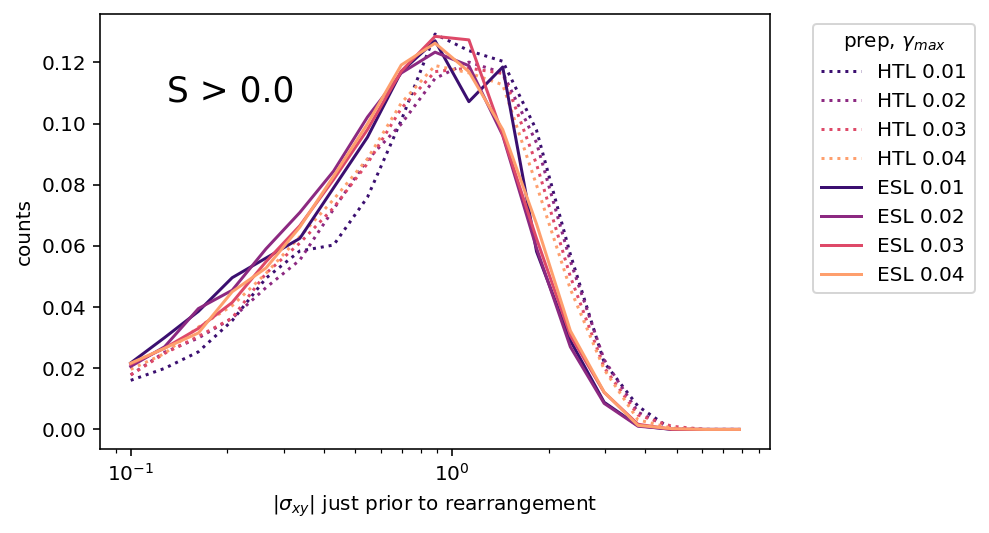

In [236]:
bins = np.geomspace(1e-1, 1e1, 20)
# bins = np.linspace(-5, 10, 20)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    d = data[0]
    out = []
    for i in range(0, 5):
        frame = d["d2min"]["frame"][i]

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        virial_xy = d["virial_xy"]["virial_xy"]
        # for j in range(0, 40):
        #     frame_j = frame + j
        #     data[0]["d2min"]["xy_strain"][i]

        init_virial_xy = virial_xy[i]

        rearrange = np.argmax(d["d2min"]["d2min"][i*40:(i+1)*40] > 0.08, axis=0) - 1
        rearrange = np.ma.masked_equal(rearrange, -1)
        idx = np.where((rearrange.mask == False) & (soft.to_numpy()[0] > 0))[0]
        # idx = np.where((rearrange.mask == False))[0]

    #     rearrange = np.any(rearrange, axis=0)

        max_xy_strain = d["d2min"]["xy_strain"][i*40:(i+1)*40][:,idx].T
        rearrange = rearrange[idx].data
        m2 = []
        virs = []
        for k, r in enumerate(rearrange):
            m2.append(max_xy_strain[k, r])
            virs.append(np.abs(virial_xy[i*40 + r][k]))
        
        out.append(virs)
    max_xy_strain = np.concatenate(out)
    H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

plt.xscale('log')
plt.xlabel(r"$|\sigma_{xy}|$ just prior to rearrangement")
plt.ylabel('counts')

plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("rearrangement_hist_virial_xy.png", dpi=300, bbox_inches="tight")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


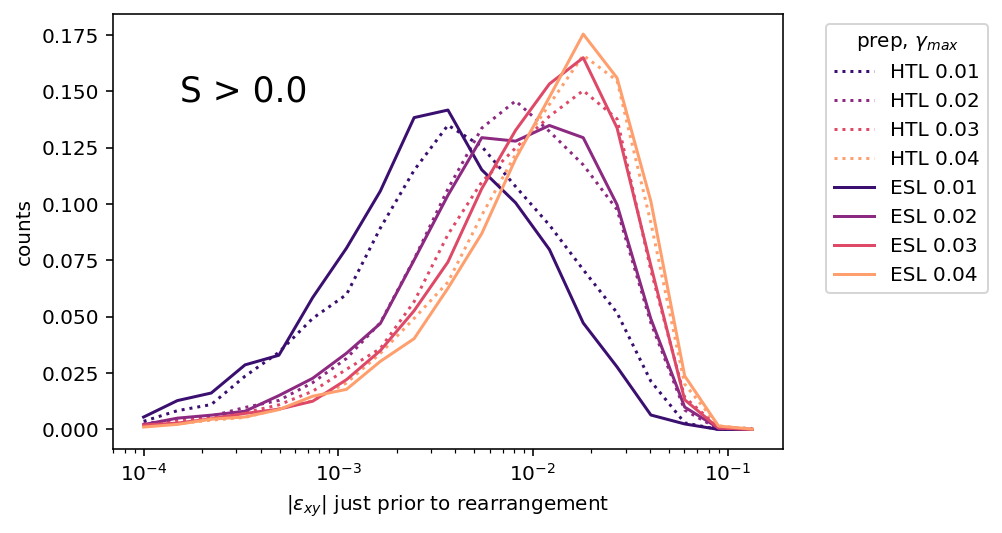

In [230]:
bins = np.geomspace(1e-4, 2e-1, 20)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    d = data[0]
    out = []
    for i in range(0, 5):
        frame = d["d2min"]["frame"][i]

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        # for j in range(0, 40):
        #     frame_j = frame + j
        #     data[0]["d2min"]["xy_strain"][i]

        rearrange = np.argmax(d["d2min"]["d2min"][i*40:(i+1)*40] > 0.08, axis=0) - 1
        rearrange = np.ma.masked_equal(rearrange, -1)
        idx = np.where((rearrange.mask == False) & (soft.to_numpy()[0] > 0))[0]
        # idx = np.where((rearrange.mask == False))[0]

    #     rearrange = np.any(rearrange, axis=0)

        max_xy_strain = d["d2min"]["xy_strain"][i*40:(i+1)*40][:,idx].T
        rearrange = rearrange[idx].data
        m2 = []
        for k, r in enumerate(rearrange):
            m2.append(np.abs(max_xy_strain[k, r]))
        
        out.append(m2)
    max_xy_strain = np.concatenate(out)
    H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

plt.xscale('log')
plt.xlabel(r"$|\epsilon_{xy}|$ just prior to rearrangement")
plt.ylabel('counts')

plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("rearrangement_hist.png", dpi=300, bbox_inches="tight")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


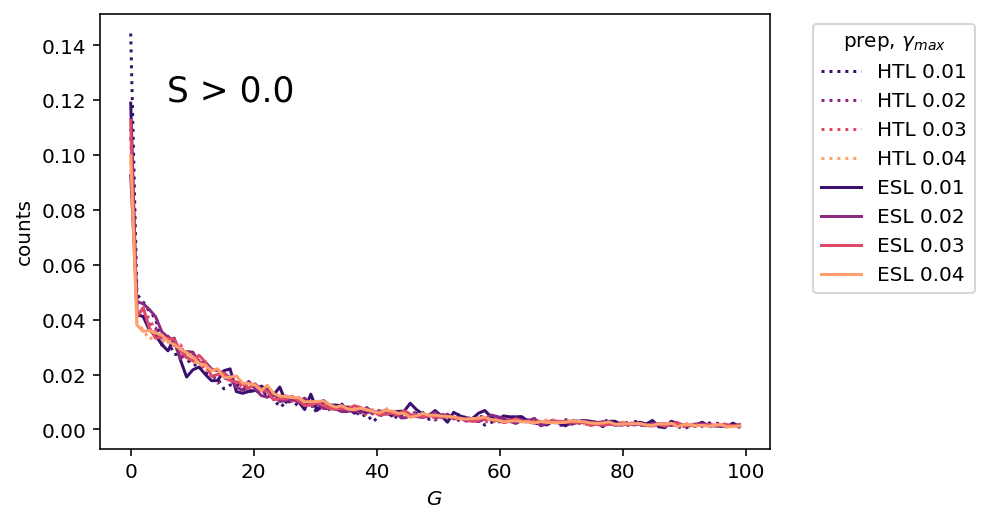

In [245]:
# bins = np.geomspace(1e-1, 1e4, 20)
bins = np.linspace(0, 100, 100)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    d = data[0]
    out = []
    for i in range(0, 5):
        frame = d["d2min"]["frame"][i]

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        virial_xy = d["virial_xy"]["virial_xy"]
        # for j in range(0, 40):
        #     frame_j = frame + j
        #     data[0]["d2min"]["xy_strain"][i]

        init_virial_xy = virial_xy[i]

        rearrange = np.argmax(d["d2min"]["d2min"][i*40:(i+1)*40] > 0.08, axis=0) - 1
        rearrange = np.ma.masked_equal(rearrange, -1)
        idx = np.where((rearrange.mask == False) & (soft.to_numpy()[0] > 0))[0]
        # idx = np.where((rearrange.mask == False))[0]

    #     rearrange = np.any(rearrange, axis=0)

        max_xy_strain = d["d2min"]["xy_strain"][i*40:(i+1)*40][:,idx].T
        rearrange = rearrange[idx].data
        m2 = []
        virs = []
        for k, r in enumerate(rearrange):
            m2.append(np.abs(max_xy_strain[k, r]))
            virs.append(np.abs(virial_xy[i*40 + r][k] - virial_xy[i*40][k])/np.abs(max_xy_strain[k, r]))
        
        out.append(virs)
    max_xy_strain = np.concatenate(out)
    H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

# plt.xscale('log')
plt.xlabel(r"$G$ ")
plt.ylabel('counts')

plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("rearrangement_hist_virial_xy.png", dpi=300, bbox_inches="tight")

In [ ]:
bins = np.geomspace(1e-1, 1e1, 20)
# bins = np.linspace(-5, 10, 20)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    d = data[0]
    out = []
    out2 = []
    for i in range(0, 5):
        frame = d["d2min"]["frame"][i]

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        virial_xy = d["virial_xy"]["virial_xy"]
        # for j in range(0, 40):
        #     frame_j = frame + j
        #     data[0]["d2min"]["xy_strain"][i]

        init_virial_xy = virial_xy[i]


        rearrange = np.argmax(d["d2min"]["d2min"][i*40:(i+1)*40] > 0.08, axis=0)
        d2mins = d["d2min"]["d2min"][rearrange]
        rearrange = np.ma.masked_equal(rearrange - 1, -1)
        idx = np.where((rearrange.mask == False) & (soft.to_numpy()[0] > 0))[0]
        # idx = np.where((rearrange.mask == False))[0]

    #     rearrange = np.any(rearrange, axis=0)

        max_xy_strain = d["d2min"]["xy_strain"][i*40:(i+1)*40][:,idx].T
        rearrange = rearrange[idx].data
        m2 = []
        virs = []
        d2ms = []
        for k, r in enumerate(rearrange):
            m2.append(max_xy_strain[k, r])
            virs.append(np.abs(virial_xy[i*40 + r][k]))
            d2ms.append()
        
        out.append(virs)
        out2.append()
    max_xy_strain = np.concatenate(out)
    # H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    # plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    plt.hist2d()
    break

plt.xscale('log')
plt.xlabel(r"$|\sigma_{xy}|$ just prior to rearrangement")
plt.ylabel('counts')

plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("rearrangement_hist_virial_xy.png", dpi=300, bbox_inches="tight")